In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import tqdm.notebook
import time
from sklearn import preprocessing
import glob
from skimage.measure import block_reduce
import tqdm.notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('classic')

import src.utils
from src.utils import set_gpytorch_settings

set_gpytorch_settings()
# Kernel Imports
from gpytorch.kernels import PeriodicKernel
from src.custom_kernel import MinKernel, AR2Kernel, MaternKernel, LinearKernel
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.constraints import Interval
# from gpytorch.metrics import mean_standardized_log_loss, quantile_coverage_error, mean_squared_error, mean_absolute_error
from src.custom_kernel import noise_lower, noise_upper, noise_init

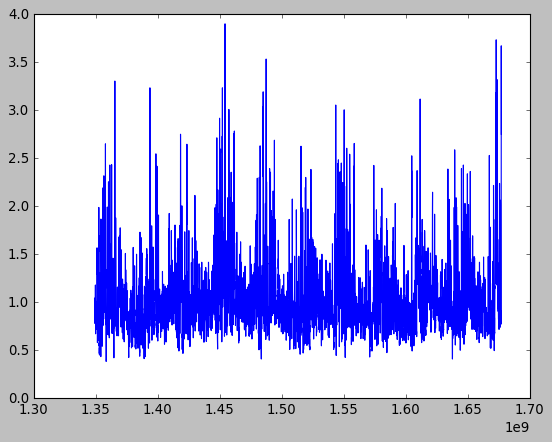

In [2]:
df = pd.read_feather('../data/feather/46221_9999_wave_height.feather')
# df = pd.read_feather('../data/feather/combined/combined_data.feather')
parameters_wave = ['time', 'wave_height']
parameters_temp = ['time', 'sea_surface_temperature']
df_as_np = df \
    .loc[:, parameters_wave] \
    .astype(float) \
    .replace(to_replace = [999.0, 99.0, 9999.0], value = np.nan) \
    .to_numpy()
using_sk = block_reduce(df_as_np, block_size=(24,1), func=np.mean).astype(float)
plt.plot(using_sk[:-1,0], using_sk[:-1,1])

In [3]:
X = torch.tensor(using_sk[:-1,0]).float().cuda()#.type(torch.double)
y = torch.tensor(using_sk[:-1,1]).float().cuda()#.type(torch.double)
X = X.reshape(-1,1)
y = y.reshape(-1,1)

X = X[~torch.any(y.isnan(), dim=1)]
y = y[~torch.any(y.isnan(), dim=1)]
y = y.flatten()
X_old = X

In [4]:
def scaler(a, X_old=X_old, center=True):
    if center is True:
        a = a - X_old.min(0).values
    return a / (X_old.max(0).values - X_old.min(0).values)
X = scaler(X, X_old)
y = y.log()

In [5]:
test_n = 800
train_x = X[test_n:].contiguous().cuda()
train_y = y[test_n:].contiguous().cuda()
test_x = X[-test_n:].contiguous().cuda()
test_y = y[-test_n:].contiguous().cuda()

In [6]:
# Generate the train_loader and train_dataset
train_loader, train_dataset, test_loader, test_dataset = src.utils.create_train_loader_and_dataset(
    train_x, train_y, test_x, test_y)
data_compact = [train_x, train_y, test_x, test_y, train_loader, train_dataset, test_loader, test_dataset]

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class StandardApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MeanFieldApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class MAPApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def make_orthogonal_vs(model, train_x):
    mean_inducing_points = torch.randn(1000, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)
    covar_inducing_points = torch.randn(100, train_x.size(-1), dtype=train_x.dtype, device=train_x.device)

    covar_variational_strategy = gpytorch.variational.VariationalStrategy(
        model, covar_inducing_points,
        gpytorch.variational.CholeskyVariationalDistribution(covar_inducing_points.size(-2)),
        learn_inducing_locations=True
    )

    variational_strategy = gpytorch.variational.OrthogonallyDecoupledVariationalStrategy(
        covar_variational_strategy, mean_inducing_points,
        gpytorch.variational.DeltaVariationalDistribution(mean_inducing_points.size(-2)),
    )
    return variational_strategy

class OrthDecoupledApproximateGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points.size(-2))
        variational_strategy = make_orthogonal_vs(self, train_x)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class SpectralDeltaGP(gpytorch.models.ExactGP):
    # def __init__(self, train_x, train_y, kernel, num_deltas, noise_init=None):
    #     likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-11))
    #     likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
    #     likelihood.noise = 1e-2
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.DeltaVariationalDistribution(inducing_points)
        #variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-2))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        #super(SpectralDeltaGP, self).__init__(train_x, train_y, likelihood)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        #base_covar_module = kernel #gpytorch.kernels.SpectralDeltaKernel(num_dims=train_x.size(-1), num_deltas=num_deltas)
        #base_covar_module.initialize_from_data(train_x[0], train_y[0])
        self.covar_module = kernel#gpytorch.kernels.ScaleKernel(base_covar_module)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [8]:
Mat32 = MaternKernel(nu=1.5)
Mat12 = MaternKernel(nu=0.5)
Mat52 = MaternKernel(nu=2.5)
RBF = RBFKernel()
Per_Day = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=scaler(60*24, center=False) / 100,
    upper_bound=scaler(60*24, center=False) * 100,
    initial_value=scaler(60*24, center=False))
)
Per_Month = PeriodicKernel(
    period_length_constraint=Interval(
    lower_bound=scaler(60*24*30, center=False) / 100,
    upper_bound=scaler(60*24*30, center=False) * 100,
    initial_value=scaler(60*24*30, center=False))
)
Per_Arb = PeriodicKernel()

k_1 = [Mat32, Mat12, RBF, Per_Day, Per_Month, Per_Arb]
k_2 = [*k_1]
k_3 = [*k_1]
kernel_dict = {
    Mat32: 'Mat32',
    Mat12: 'Mat12',  # Very Rough - in continuous time AR(1) process in discrete time
    Mat52: 'Mat52', # Matern 5/2 (Default)
    RBF: 'RBF',
    Per_Day: 'Per_Day',
    Per_Month: 'Per_Month',
    Per_Arb: 'Per_Arb'}
from gpytorch.kernels import RQKernel
RQKernel()

RQKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_alpha_constraint): Positive()
)

Training_exactGP_Kernel_Experiment:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\dcaos\anaconda3\envs\GPs\lib\site-packages\gpytorch\utils\linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 119222.5703125 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


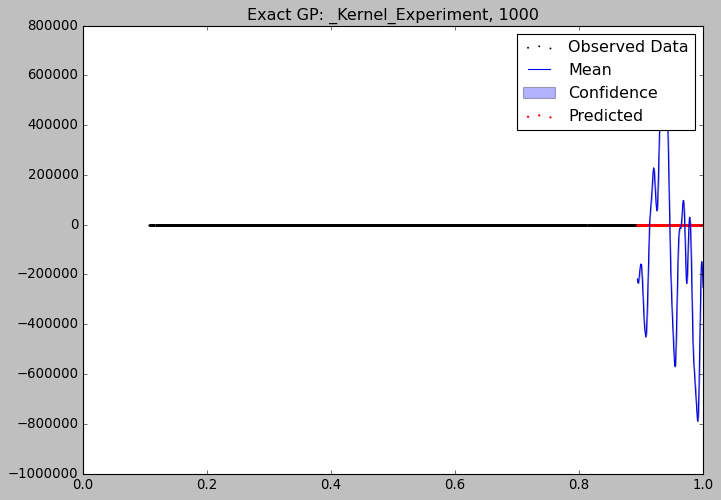

tensor(6058.6172, grad_fn=<AddBackward0>) AdditiveKernel(
  (kernels): ModuleList(
    (0): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Interval(2.500E-02, 7.500E+00)
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
    (1): ScaleKernel(
      (base_kernel): ProductKernel(
        (kernels): ModuleList(
          (0): PeriodicKernel(
            (raw_lengthscale_constraint): Positive()
            (raw_period_length_constraint): Positive()
          )
          (1): RBFKernel(
            (raw_lengthscale_constraint): Positive()
            (distance_module): Distance()
          )
        )
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)


In [15]:
## Kernel Experimentation for periodicity
# kernel = ScaleKernel(PeriodicKernel()) +ScaleKernel(PeriodicKernel()*RBFKernel())  + ScaleKernel(PeriodicKernel()*RBFKernel()) + ScaleKernel(PeriodicKernel()*RBFKernel())

kernel = ScaleKernel(RBFKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel())
kernel_1 = ScaleKernel(MaternKernel(nu=2.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())

kernel_2 = ScaleKernel(MaternKernel(nu=1.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())

kernel_3 = ScaleKernel(MaternKernel(nu=0.5)) + ScaleKernel(PeriodicKernel() * RBFKernel())

k_list = [kernel, kernel_1, kernel_2, kernel_3]
bic_save = []
for kernel in k_list[1:2]:
    exact_gp = src.utils.TrainTestPlotSaveExactGP(
        ExactGPModel, kernel,
        train_x, train_y, test_x, test_y, num_iter=1000, lr=0.02,
        name=f'_Kernel_Experiment')
    exact_gp.test_eval_exact_gp()
    exact_gp.plot()
    bic_save.append(exact_gp.get_BIC())
    print(bic_save[-1], kernel)


In [10]:
print(bic_save)

[tensor(2364.9941, grad_fn=<AddBackward0>)]


In [11]:
# # kernel = ScaleKernel(RBFKernel()) + ScaleKernel(MaternKernel()) + ScaleKernel(PeriodicKernel())
# kernel = ScaleKernel(RBFKernel() * RBFKernel()) + ScaleKernel(PeriodicKernel() * MaternKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel()) + ScaleKernel(PeriodicKernel() * RBFKernel())
# # kernel = ScaleKernel(RBFKernel()) #+ ScaleKernel(MaternKernel()) + ScaleKernel(PeriodicKernel())
# kernel = ScaleKernel(MaternKernel(nu=0.5))
#
#
#
# results = []
# # for i in range(150, 200):
# exact_gp = src.utils.TrainTestPlotSaveExactGP(
#     ExactGPModel, kernel,
#     train_x, train_y, test_x, test_y, num_iter=250,
#     name=f'_Mat_RBF')
# exact_gp.test_eval_exact_gp()
# exact_gp.plot()
# bic = exact_gp.get_BIC()
# print(bic, kernel)
# results.append([bic, kernel])
# # del exact_gp
# # print(f'BIC: {exact_gp.get_BIC()}')
# # print(f'AVG Error: {error}')

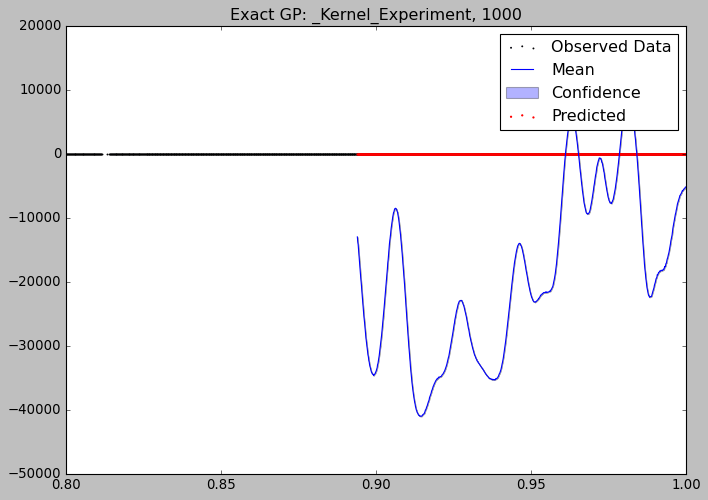

In [12]:
exact_gp.plot(set_x_limit=(.8,1))#, set_y_limit=(0,4))

In [13]:
# print(exact_gp.get_BIC())
del exact_gp


In [14]:
## Test all combinations of kernels

# for i in k_1:
#     for j in k_2:
#         for z in k_3:
#             kernel = (
#                 ScaleKernel(i) +
#                 ScaleKernel(j) +
#                 ScaleKernel(z))
#             exact_gp = src.utils.TrainTestPlotSaveExactGP(
#                 ExactGPModel, kernel,
#                 train_x, train_y, test_x, test_y,
#                 name=f'{str(kernel_dict[i])}{str(kernel_dict[j])}{str(kernel_dict[z])}')
#             exact_gp.test_eval_exact_gp()